In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from mlxtend.association import apriori
from mlxtend.preprocessing import OnehotTransactions
from scipy import stats


# Pandas Printing Options
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_style('white')

# LOAD

In [2]:
data = pd.read_csv("../data/injuries_2013_present.csv", index_col=['DATE'], parse_dates=['DATE'])

# FILTER

In [3]:
data = data['2017-01-23']
data.shape

(102, 28)

In [4]:
data['2017-01-23'].head()

,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-23 17:35:00,17:35,BROOKLYN,11218.000,40.643,-73.991,"(40.642685, -73.99122)",FORT HAMILTON PARKWAY,40 STREET,NaN,1,0,2,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,3603448,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2017-01-23 17:35:00,17:35,QUEENS,11694.000,40.583,-73.828,"(40.583138, -73.82798)",ROCKAWAY FREEWAY,BEACH 106 STREET,NaN,1,0,2,0,0,0,0,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,3603513,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2017-01-23 18:05:00,18:05,MANHATTAN,10025.000,40.791,-73.969,"(40.790928, -73.96893)",WEST 93 STREET,COLUMBUS AVENUE,NaN,1,0,3,0,0,0,0,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,3603223,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2017-01-23 18:09:00,18:09,NaN,nan,40.679,-73.865,"(40.678955, -73.86516)",ELDERTS LANE,NaN,NaN,1,0,3,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3603314,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2017-01-23 19:00:00,19:00,QUEENS,11377.000,40.749,-73.900,"(40.748955, -73.8997)",63 STREET,37 AVENUE,NaN,1,0,2,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,3603422,PASSENGER VEHICLE,NaN,NaN,NaN,NaN


# CONTRIBUTING FACTORS

In [5]:
contributing_factors = data[['CONTRIBUTING FACTOR VEHICLE 1',
                                 'CONTRIBUTING FACTOR VEHICLE 2',
                                 'CONTRIBUTING FACTOR VEHICLE 3',
                                 'CONTRIBUTING FACTOR VEHICLE 4',
                                 'CONTRIBUTING FACTOR VEHICLE 5']]

# HELPER FUNCTIONS

In [6]:
def filter_set(row):
    filtered = [element for element in row if str(element) != 'nan']
    filtered = [element for element in filtered if str(element) != 'Unspecified']
    return filtered

def my_generator(contributing_factors):
    for i in contributing_factors.as_matrix():
        if filter_set(i):
            yield filter_set(i)
            
def get_factors(dataset):
    oht = OnehotTransactions()
    oht_ary = oht.fit(dataset).transform(dataset)
    return pd.DataFrame(oht_ary, columns=oht.columns_)

# GET FACTORS

In [7]:
factors_obj = my_generator(contributing_factors)

contributing_factors_to_injuries = [fact for fact in factors_obj]

df = get_factors(contributing_factors_to_injuries)

In [8]:
n = df.shape[0]

# RUN APRIORI

In [9]:
results = apriori(df, min_support=0.0001, use_colnames=True)
results['count'] = results['support'] * n
results

,support,itemsets,length,count
0,0.016,[Alcohol Involvement],1,1.000
1,0.047,[Backing Unsafely],1,3.000
2,0.359,[Driver Inattention/Distraction],1,23.000
3,0.344,[Failure to Yield Right-of-Way],1,22.000
4,0.031,[Following Too Closely],1,2.000
5,0.016,[Passing or Lane Usage Improper],1,1.000
6,0.062,[Pavement Slippery],1,4.000
7,0.094,[Pedestrian/Bicyclist/Other Pedestrian Error/C...,1,6.000
8,0.016,[Turning Improperly],1,1.000
9,0.031,[View Obstructed/Limited],1,2.000


In [10]:
reasons = df.sum().sort_values(ascending=False)
reasons

Driver Inattention/Distraction                           23
Failure to Yield Right-of-Way                            22
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion     6
Pavement Slippery                                         4
Backing Unsafely                                          3
View Obstructed/Limited                                   2
Following Too Closely                                     2
Turning Improperly                                        1
Passing or Lane Usage Improper                            1
Alcohol Involvement                                       1
dtype: int64

# PLOT

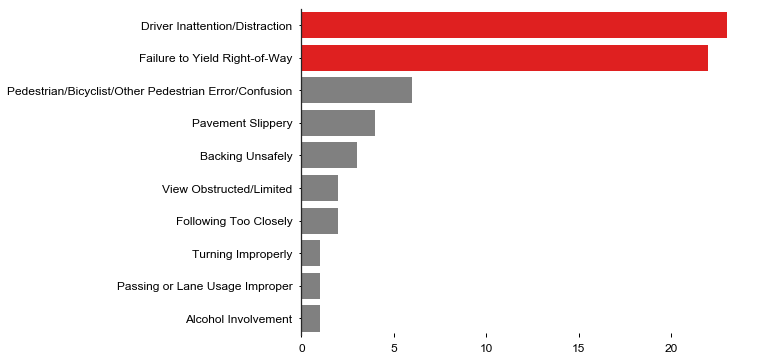

In [12]:
labels = reasons.index
values = reasons.values

plt.figure(figsize=(8, 6))
colors = ['gray' if (x < 15) else 'red' for x in values]
sns.barplot(values, labels, palette=colors)
plt.tick_params(direction='inout', length=4, width=1, colors='black')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
sns.despine(bottom=True)

In [13]:
# SAVE FOR CARTODB
data.to_csv('../data/most_dangerous_day.csv')

# Answering Erilia's Question

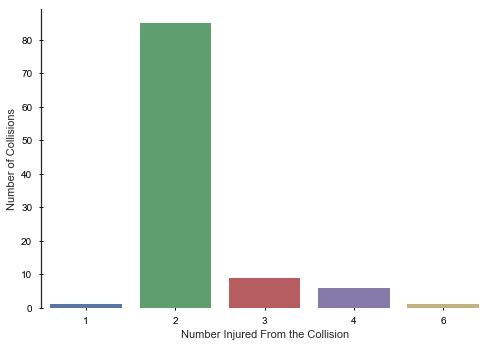

In [14]:
# Q: Is there some accident on Jan 23, 2017 that got a massive amount of people injured?
# A: There are 16 collisions with 3 or more pedestrains injured.
# 86 collisions had 2 or less! I hope that answers your question.

collision_to_num_injured_freq = stats.itemfreq(data['NUMBER OF PEDESTRIANS INJURED'])

labels = collision_to_num_injured_freq[:, 0]
values = collision_to_num_injured_freq[:, 1]

sns.barplot(labels, values)
plt.tick_params(direction='inout', length=4, width=1, colors='black')
plt.ylabel('Number of Collisions')
plt.xlabel('Number Injured From the Collision')
sns.despine(bottom=True)

In [15]:
data['NUMBER OF PEDESTRIANS INJURED'].value_counts(sort=False)

1     1
2    85
3     9
4     6
6     1
Name: NUMBER OF PEDESTRIANS INJURED, dtype: int64